In [23]:
import os
import numpy as np
from PIL import Image
import torch
import json
from random import randint
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from tqdm import tqdm

In [24]:
class BDD100KDataset(Dataset):

    def __init__(self, path, size, split):
        self.path = path
        self.size = size
        self.split = split

        self.annotation_path = os.path.join(path, "labels", f"det_{split}.txt")

        self.load_annotations()

    def load_annotations(self):

        # load all images id can be used
        image_ids = []

        for file in os.listdir(
            os.path.join(self.path, "images", self.size, self.split)
        ):
            if file.endswith(".jpg"):
                image_ids.append(file)

        image_ids = set(image_ids)

        self.A_annotations = []
        self.B_annotations = []

        with open(
            os.path.join(self.path, "labels", "det_20", f"det_{self.split}.json")
        ) as f:
            annotations = json.load(f)

            for image_label in tqdm(
                annotations, desc=f"Loading BDD100K {self.size} {self.split}"
            ):
                if image_label["name"] not in image_ids:
                    continue

                timeofday = image_label["attributes"]["timeofday"]

                label = {
                    "name": image_label["name"],
                }

                if timeofday == "daytime":
                    self.A_annotations.append(label)
                elif timeofday == "night":
                    self.B_annotations.append(label)

        print(f"Loaded {len(self.A_annotations)} daytime images")
        print(f"Loaded {len(self.B_annotations)} nighttime images")

    def __len__(self):
        return max(len(self.A_annotations), len(self.B_annotations))

    def load_image(self, name):
        return Image.open(
            os.path.join(self.path, "images", self.size, self.split, name)
        ).convert("RGB")

    def __getitem__(self, idx):
        A_idx = self.A_annotations[idx % len(self.A_annotations)]
        # randomly select a B image to avoid fixed pairs
        B_idx = self.B_annotations[randint(0, len(self.B_annotations) - 1)]

        A_image = self.load_image(A_idx["name"])
        B_image = self.load_image(B_idx["name"])

        return {
            "A_image": A_image,
            "B_image": B_image,
            "A_size": A_image.size,
            "B_size": B_image.size,
        }

In [25]:
dataset = BDD100KDataset("../data/bdd100k", "100k", "train")

Loading BDD100K 100k train: 100%|██████████| 69863/69863 [00:00<00:00, 698201.19it/s]


Loaded 36728 daytime images
Loaded 27971 nighttime images


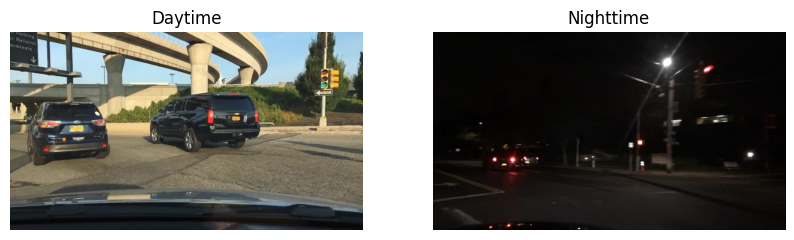

In [26]:
import matplotlib.pyplot as plt

sample = dataset[0]
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample["A_image"])
plt.title("Daytime")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample["B_image"])
plt.title("Nighttime")
plt.axis("off")

plt.show()

In [32]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [57]:
class CycleGANProcessor:
    def __init__(self, size):
        self.size = size

        self.image_transform = A.Compose(
            [
                A.Resize(size, size),
                A.HorizontalFlip(p=0.5),
                A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ToTensorV2(),
            ],
        )

    def preprocess(self, image):
        image = np.array(image)
        return self.image_transform(image=image)["image"]

    def preprocess_sample(self, sample):
        return {
            "A_image": self.preprocess(sample["A_image"]),
            "B_image": self.preprocess(sample["B_image"]),
            "A_size": sample["A_size"],
            "B_size": sample["B_size"],
        }

    def postprocess(self, image, original_size=None):
        image = (image * 0.5) + 0.5

        if original_size is not None:
            image = TF.resize(image, (original_size[1], original_size[0]))

        image = TF.to_pil_image(image)

        return image

In [62]:
processor = CycleGANProcessor(512)

In [63]:
sample_ = processor.preprocess_sample(sample)

In [64]:
A_image = processor.postprocess(sample_["A_image"], sample_["A_size"])

In [65]:
A_image.show()